In [67]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import os
import glob
import pickle

In [2]:
import seaborn as sns
sns.set()

In [45]:
main_dir = "E:/TDI_Capstone_Data_Repo/main-repo"
analysis_dir = "'E:\\TDI_Capstone_Data_Repo\\main-repo\\analysis_dir"
os.chdir(main_dir)
os.getcwd()

'E:\\TDI_Capstone_Data_Repo\\main-repo'

In [44]:
#inv_path = "F:/TDI_Capstone_Data_Repo/main-repo/inventories-reduced/"
#os.chdir(inv_path)
def remove_unwanted_cols(path, cols_to_rm):
    files = os.listdir(path)    
    files = list(filter(lambda f: f.endswith('.csv'), files))
    for i in tqdm(range(len(files)), desc="Progress"):
        #print(files[i])
        # load the dataframe, csv file
        df = pd.read_csv(files[i])
        df = df.drop(cols_to_rm, axis=1)
        # save the column
        df.to_csv(files[i], index=False)

def datetime_to_date(path, col_to_conv):
    # Grab all .csv files in directory
    files = os.listdir(path)    
    files = list(filter(lambda f: f.endswith('.csv'), files))
    for i in tqdm(range(len(files)), desc="Progress"):
        #print(files[i])
        # load the dataframe, csv file
        df = pd.read_csv(files[i])
        # convert the string to a datetime
        df[col_to_conv] = pd.to_datetime(df[col_to_conv], format='%Y-%m-%d')
        # reduce the datetime to a date
        df[col_to_conv] = df[col_to_conv].dt.date
        # save the column
        df.to_csv(files[i], index=False)
        
def datetime_outlier_rm(datelist, date_threshold):
    counter = 0
    for i in tqdm(range(len(datelist)), desc="Progress"):
        if datelist[i] < date_threshold:
            counter += 1
    return(counter)

def sort_df_files(path, date_idx_col):
    files = os.listdir(path)    
    files = list(filter(lambda f: f.endswith('.csv'), files))
    for i in tqdm(range(len(files)), desc="Progress"):
        df = pd.read_csv(files[i])
        df = df.sort_values(by = date_idx_col)
        df.reset_index(inplace=True)
        del df['index']
        df.to_csv(files[i], index=False)
        
def individualfiles_datetime_to_date(list_dfs, col_to_conv):
    # Grab all .csv files in directory
    for i in tqdm(range(len(list_dfs)), desc="Progress"):
        #print(files[i])
        # load the dataframe, csv file
        df = pd.read_csv(list_dfs[i])
        # convert the string to a datetime
        df[col_to_conv] = pd.to_datetime(df[col_to_conv], format='%Y-%m-%d')
        # reduce the datetime to a date
        df[col_to_conv] = df[col_to_conv].dt.date
        # save the column
        df.to_csv(list_dfs[i], index=False)

### Notes on Opening
All the processed data is located in the `main-repo` folder.  I have reduced the dimensionality of some of the data and have broken the data into smaller, more manageable pieces.  I did lose some of the later sale items.  Perhaps I will try to add them in, but I ahve spent too much time at this point trying get everything to get out nicely.
- `inventories-reduced`
- `reduced_labResults-Apr2021`
- `reduced_saleitems0`
- `reduced_saleitems1`

In [5]:
inv    = "E:/TDI_Capstone_Data_Repo/main-repo/inventories-reduced/*.csv"
labres = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_labResults-Apr2021/*.csv"
salei0 = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_saleitems0/*.csv"
salei1 = "E:/TDI_Capstone_Data_Repo/main-repo/reduced_saleitems1/*.csv"

#### Engage the Dask Client
Utilizing my full machine for the computations.

In [6]:
client = Client(processes=True)
client

Client Scheduler: tcp://127.0.0.1:51922 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 7.60 GiB


In [66]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [6]:
#si_date_cols = ['sold_at']
si0_df = dd.read_csv(salei0, sep=',', encoding = "utf-8", blocksize = '64MB')
si1_df = dd.read_csv(salei1, sep=',', encoding = "utf-8", blocksize = '64MB')

#labres_date_cols = ['created_at','updated_at','tested_at','received_at']
col_type_fixes = {'external_id': 'object'}
labres_df =  dd.read_csv(labres, sep=',', encoding = "utf-8", dtype = col_type_fixes, blocksize = '64MB')

#inv_date_cols = ['created_at', 'updated_at']
inv_df =  dd.read_csv(inv, sep=',', encoding = "utf-8", dtype = col_type_fixes, blocksize = '64MB')

#### Compute the Shapes of Each DataFrame

In [ ]:
print(dask.compute(si0_df.shape))
print(dask.compute(si1_df.shape))
print(dask.compute(labres_df.shape))
print(dask.compute(inv_df.shape))

#### Shapes of the 4 Main Datasets
##### Apr 25, 2021
- `si0_df`: (90000000, 7)
- `si1_df`: (29624167, 7)
- `inv_df`: (48201461, 14)
- `labres_df`: (1993093, 35) 

### Inventory Dataset
- Columns
    - global_id
    - created_at (datetime, to be reduced to %Y-%m-%d)
    - updated_at (datetime, to be reduced to %Y-%m-%d)
    - mme_id
    - user_id
    - area_id
    - batch_id
    - is_initial_inventory (bool)
    - inventory_packaged_at (datetime, found to not be useful, many errors)
    - qty (int64)
    - inventory_type_id
    - sent_for_testing (bool)
    - lab_results_attested

In [8]:
inv_df.columns

Index(['global_id', 'created_at', 'updated_at', 'mme_id', 'user_id', 'area_id',
       'batch_id', 'is_initial_inventory', 'inventory_created_at',
       'inventory_packaged_at', 'qty', 'inventory_type_id', 'sent_for_testing',
       'lab_results_attested'],
      dtype='object')

In [9]:
len(os.listdir("F:/TDI_Capstone_Data_Repo/main-repo/inventories-reduced/"))

190

In [10]:
inv_df.head()

,global_id,created_at,updated_at,mme_id,user_id,area_id,batch_id,is_initial_inventory,inventory_created_at,inventory_packaged_at,qty,inventory_type_id,sent_for_testing,lab_results_attested
0,WAJ412598.IN1,2018-01-31,2018-02-28,WAWA1.MMDJ,WAWA1.USAM,WAJ412598.AR3,WAJ412598.BA1,False,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,WAJ412598.TY1S,False,0
1,WAJ412598.IN2,2018-01-31,2018-01-31,WAWA1.MMDJ,WAWA1.USAM,WAJ412598.AR3,WAJ412598.BA2,False,1900-01-01 00:00:00,1900-01-01 00:00:00,84.0,WAJ412598.TY1S,False,0
2,WAJ412598.IN3,2018-01-31,2018-02-28,WAWA1.MMDJ,WAWA1.USAM,WAJ412598.AR3,WAJ412598.BA3,False,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,WAJ412598.TY1S,False,0
3,WAJ412598.IN4,2018-01-31,2018-02-28,WAWA1.MMDJ,WAWA1.USAM,WAJ412598.AR3,WAJ412598.BA4,False,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,WAJ412598.TY1S,False,0
4,WAJ412598.IN5,2018-01-31,2018-02-28,WAWA1.MMDJ,WAWA1.USAM,WAJ412598.AR3,WAJ412598.BA5,False,1900-01-01 00:00:00,1900-01-01 00:00:00,0.0,WAJ412598.TY1S,False,0


In [ ]:
dask.compute(inv_df['is_initial_inventory'].value_counts())

In [ ]:
dask.compute(inv_df['sent_for_testing'].value_counts())

In [ ]:
inv_df_tested_NEWinv_shape = dask.compute(inv_df[inv_df.is_initial_inventory == True][inv_df.sent_for_testing == True].shape)

In [ ]:
# Number of items that are BOTH initial_to_inventory AND sent_for_testing
inv_df_tested_NEWinv_shape[0]

In [ ]:
# Fraction of new inventory items that were tested to all new items in inventory
inv_df_tested_NEWinv_shape[0][0] / 10742234

In [ ]:
inv_path = "F:/TDI_Capstone_Data_Repo/main-repo/inventories-reduced/"
os.chdir(inv_path)
datetime_to_date(inv_path, 'created_at')
datetime_to_date(inv_path, 'updated_at')

In [ ]:
inv_path = "F:/TDI_Capstone_Data_Repo/main-repo/inventories-reduced/"
os.chdir(inv_path)
remove_unwanted_cols(inv_path, ['Unnamed: 0', 'Unnamed: 0.1'])

### Saleitems

In [12]:
salei0_dir = "F:/TDI_Capstone_Data_Repo/main-repo/reduced_saleitems0/"
salei1_dir = "F:/TDI_Capstone_Data_Repo/main-repo/reduced_saleitems1/"

In [ ]:
os.chdir(salei0_dir)
#datetime_to_date(salei0_dir, 'sold_at')
sort_df_files(salei0_dir, 'sold_at')
os.chdir(salei1_dir)
#datetime_to_date(salei1_dir, 'sold_at')
sort_df_files(salei1_dir, 'sold_at')
os.chdir(main_dir)

In [ ]:
si0_df.head()

In [ ]:
si1_df.head()

In [ ]:
si0_nunique_dates = dask.compute(si0_df.sold_at.nunique())
si1_nunique_dates = dask.compute(si1_df.sold_at.nunique())
print("si0 Number of Unique Dates: {}".format(si0_nunique_dates[0]))
print("si1 Number of Unique Dates: {}".format(si1_nunique_dates[0]))

In [ ]:
si0_min_max_date = dask.compute(si0_df.sold_at.min(), si0_df.sold_at.max())
si1_min_max_date = dask.compute(si1_df.sold_at.min(), si1_df.sold_at.max())

In [ ]:
print(si0_min_max_date)
print(si1_min_max_date)

In [ ]:
si0_unique_dates = dask.compute(si0_df.sold_at.unique())
si1_unique_dates = dask.compute(si1_df.sold_at.unique())

In [ ]:
si1_dates = np.array(si1_unique_dates[0])
si1_dates_final = [datetime.datetime.strptime(x, "%Y-%m-%d").date() for x in si1_dates]

In [ ]:
si1_dates_final[0]

In [ ]:
print(datetime_outlier_rm(si0_unique_dates, datetime.date(2017, 1, 1)))
print(datetime_outlier_rm(si1_dates_final, datetime.date(2017, 1, 1)))

In [ ]:
si0_count_dates = dask.compute(si0_df.sold_at.value_counts())
si1_count_dates = dask.compute(si1_df.sold_at.value_counts())

In [ ]:
si0_count_dates[0]

In [ ]:
si1_count_dates[0]

In [13]:
si1_sf_path = "F:\\TDI_Capstone_Data_Repo\\main-repo\\single-file-repo\\saleitems1-sf.csv"
#si1_df.to_csv(si1_sf_path, single_file=True, index=False)

In [14]:
si1_sf_df = dd.read_csv(si1_sf_path, sep=',', encoding = "utf-8", blocksize = '64MB')

In [15]:
si1_sf_df.head()

,global_id,mme_id,inventory_id,sold_at,qty,unit_price,price_total
0,WAR414714.SI1HMQ9O,WAWA1.MMXZ,WAR414714.IN96FKP,2019-03-07,1.0,7.48,7.48
1,WAR414714.SI1HMQZN,WAWA1.MMXZ,WAR414714.IN91NZM,2019-03-07,1.0,6.80,6.80
2,WAR414714.SI1HMQYZ,WAWA1.MMXZ,WAR414714.IN92PMX,2019-03-07,1.0,3.40,3.40
3,WAR414714.SI1HMQXY,WAWA1.MMXZ,WAR414714.IN9H7YD,2019-03-07,1.0,17.01,17.01
4,WAR414714.SI1HMQXV,WAWA1.MMXZ,WAR414714.IN9DO0B,2019-03-07,1.0,3.40,3.40


In [16]:
si1_groupbyDate = dask.compute(si1_sf_df[si1_sf_df.price_total > 0].groupby(['sold_at', 'mme_id'])['price_total'].sum())

In [17]:
si1_groupbyDate[0]

sold_at     mme_id     
2019-02-12  WAWA1.MML4      145.80
2019-02-13  WAWA1.MML4     1161.86
2019-02-14  WAWA1.MML4     7686.26
2019-02-15  WAWA1.MML4     8213.42
2019-02-16  WAWA1.MML4     7269.80
                            ...   
2019-08-01  WAWA1.MMA1     4675.00
            WAWA1.MMR5     6968.71
2019-08-07  WAWA1.MMEH     2070.00
2019-08-12  WAWA1.MMJG      730.00
2019-08-18  WAWA1.MM1F7    2108.50
Name: price_total, Length: 70249, dtype: float64

In [18]:
si0_groupbyDate = dask.compute(si0_df[si0_df.price_total > 0].groupby(['sold_at', 'mme_id'])['price_total'].sum())

In [19]:
si0_groupbyDate[0]

sold_at     mme_id     
1900-01-01  WAWA1.MMJY      2800.00
2017-11-05  WAWA1.MM101    27534.67
            WAWA1.MM10C    30047.46
            WAWA1.MM10U     1175.85
            WAWA1.MM12K    48429.16
                             ...   
2019-04-12  WAWA1.MM4B        75.75
            WAWA1.MMF5       680.00
2019-04-13  WAWA1.MM10M     1119.00
            WAWA1.MM10N     1251.00
            WAWA1.MMMO       916.00
Name: price_total, Length: 250043, dtype: float64

In [20]:
si0_groupbyDate1 = dask.compute(si0_df[si0_df.price_total > 0].groupby(['sold_at', 'mme_id'])['inventory_id'].value_counts())

In [21]:
si0_groupbyDate1

(sold_at     mme_id       inventory_id
 1900-01-01  WAWA1.MMJY   WAWA1.MMJY         3
 2017-11-05  WAWA1.MM101  WAWA1.MM101     1706
             WAWA1.MM10C  WAWA1.MM10C     2620
             WAWA1.MM10U  WAWA1.MM10U      145
             WAWA1.MM12K  WAWA1.MM12K     3760
                                          ... 
 2019-04-12  WAWA1.MM4B   WAWA1.MM4B         2
             WAWA1.MMF5   WAWA1.MMF5         2
 2019-04-13  WAWA1.MM10M  WAWA1.MM10M       44
             WAWA1.MM10N  WAWA1.MM10N       61
             WAWA1.MMMO   WAWA1.MMMO        33
 Name: inventory_id, Length: 250043, dtype: int64,)

Only 3 dates that are emphatically false in the records.  There definitely was not any products sold in the year 1900 that would have made it to the records

### Lab Results

In [22]:
labres_dir = "F:/TDI_Capstone_Data_Repo/main-repo/reduced_labResults-Apr2021/"
labres_date_cols = ['created_at','updated_at','tested_at','received_at']

In [23]:
labres_df.head()

,global_id,created_at,mme_id,user_id,external_id,inventory_id,updated_at,status,testing_status,batch_id,...,microbial_status,mycotoxin_status,metal_status,pesticide_status,solvent_status,foreign_matter_stems,foreign_matter_seeds,test_for_terpenes,high_thc_flag,high_cbd_flag
0,NaN,2018-01-31,WAWA1.MMCY,WAWA1.US29D,5275985106676286,WAJ412964.INCP,2018-01-31,not tested,completed,WAJ412964.BA1JS,...,completed,completed,NaN,NaN,completed,False,False,False,False,False
1,WAJ412964.LR2,2018-01-31,WAWA1.MMCY,WAWA1.US29D,4129640000001061,WAJ412964.ING1,2018-01-31,passed,completed,WAJ412964.BA1LC,...,completed,completed,NaN,NaN,completed,False,False,False,False,False
2,NaN,2018-01-31,WAWA1.MMCY,WAWA1.US29D,5275985106676286,WAJ412964.INCP,2018-01-31,not tested,completed,WAJ412964.BA1JS,...,completed,completed,NaN,NaN,completed,False,False,False,False,False
3,NaN,2018-01-31,WAWA1.MMCY,WAWA1.US29D,5275985106676286,WAJ412964.INCP,2018-01-31,not tested,completed,WAJ412964.BA1JS,...,completed,completed,NaN,NaN,completed,False,False,False,False,False
4,NaN,2018-01-31,WAWA1.MMCY,WAWA1.US29D,5275985106676286,WAJ412964.INCP,2018-01-31,not tested,completed,WAJ412964.BA1JS,...,completed,completed,NaN,NaN,completed,False,False,False,False,False


In [ ]:
os.chdir(labres_dir)
#datetime_to_date(labres_dir, 'created_at')
#datetime_to_date(labres_dir, 'updated_at')
#datetime_to_date(labres_dir, 'tested_at')
#datetime_to_date(labres_dir, 'received_at')
os.chdir(main_dir)

In [24]:
dask.compute(labres_df.mme_id.nunique())

(453,)

In [25]:
labres_df.columns

Index(['global_id', 'created_at', 'mme_id', 'user_id', 'external_id',
       'inventory_id', 'updated_at', 'status', 'testing_status', 'batch_id',
       'for_mme_id', 'lab_user_id', 'tested_at', 'received_at', 'type',
       'foreign_matter', 'cannabinoid_status', 'cannabinoid_d9_thca_percent',
       'cannabinoid_d9_thca_mg_g', 'cannabinoid_d9_thc_percent',
       'cannabinoid_d9_thc_mg_g', 'cannabinoid_cbd_percent',
       'cannabinoid_cbd_mg_g', 'cannabinoid_cbda_percent',
       'cannabinoid_cbda_mg_g', 'microbial_status', 'mycotoxin_status',
       'metal_status', 'pesticide_status', 'solvent_status',
       'foreign_matter_stems', 'foreign_matter_seeds', 'test_for_terpenes',
       'high_thc_flag', 'high_cbd_flag'],
      dtype='object')

In [26]:
labres_df[['inventory_id', 'mme_id', 
           'type', 
           'cannabinoid_d9_thca_percent', 'cannabinoid_d9_thc_percent', 
           'cannabinoid_cbd_percent', 'cannabinoid_cbda_percent', 
           'high_thc_flag', 'high_cbd_flag']].head()

,inventory_id,mme_id,type,cannabinoid_d9_thca_percent,cannabinoid_d9_thc_percent,cannabinoid_cbd_percent,cannabinoid_cbda_percent,high_thc_flag,high_cbd_flag
0,WAJ412964.INCP,WAWA1.MMCY,intermediate_product,75.60,6.80,2.9,0.00,False,False
1,WAJ412964.ING1,WAWA1.MMCY,harvest_materials,19.77,0.32,0.0,0.53,False,False
2,WAJ412964.INCP,WAWA1.MMCY,intermediate_product,75.60,6.80,2.9,0.00,False,False
3,WAJ412964.INCP,WAWA1.MMCY,intermediate_product,75.60,6.80,2.9,0.00,False,False
4,WAJ412964.INCP,WAWA1.MMCY,intermediate_product,75.60,6.80,2.9,0.00,False,False


In [27]:
labres_types = dask.compute(labres_df.type.value_counts())

In [28]:
labres_status = dask.compute(labres_df.status.value_counts())

In [29]:
labres_hthc_flag = dask.compute(labres_df.high_thc_flag.value_counts())
labres_hcbd_flag = dask.compute(labres_df.high_cbd_flag.value_counts())

In [30]:
print(labres_types[0])
print(labres_status[0])
print(labres_hthc_flag[0])
print(labres_hthc_flag[0])

end_product             1340791
marijuana                251988
harvest_materials        251181
intermediate_product     148963
mature_plant                 41
waste                         5
immature_plant                3
Name: type, dtype: int64
passed        1971611
failed          21467
not tested         15
Name: status, dtype: int64
False    1958144
True       34949
Name: high_thc_flag, dtype: int64
False    1958144
True       34949
Name: high_thc_flag, dtype: int64


In [31]:
labres_test_type_status = dask.compute(labres_df.groupby(['type'])['status'].value_counts())

In [32]:
labres_test_type_status[0]

type                  status    
end_product           passed        1340775
                      failed             16
harvest_materials     passed         247652
                      failed           3529
intermediate_product  passed         147566
                      failed           1392
                      not tested          5
marijuana             passed         235449
                      failed          16529
                      not tested         10
waste                 passed              4
                      failed              1
mature_plant          passed             41
immature_plant        passed              3
Name: status, dtype: int64

In [33]:
labres_test_type_status = dask.compute(labres_df.groupby(['type'])['status'].value_counts())

In [34]:
labres_unique_mme_ids = dask.compute(labres_df.mme_id.unique())

In [35]:
out_mme_ids = list(labres_unique_mme_ids[0])
out_mme_ids

['WAWA1.MMCY',
 'WAWA1.MMWS',
 'WAWA1.MM174',
 'WAWA1.MML9',
 'WAWA1.MMYT',
 'WAWA1.MM1DF',
 'WAWA1.MMQP',
 'WAWA1.MM9U',
 'WAWA1.MM1B9',
 'WAWA1.MMN',
 'WAWA1.MMFM',
 'WAWA1.MMKX',
 'WAWA1.MMCX',
 'WAWA1.MML2',
 'WAWA1.MM38',
 'WAWA1.MMD4',
 'WAWA1.MMVW',
 'WAWA1.MMX7',
 'WAWA1.MM8X',
 'WAWA1.MMS3',
 'WAWA1.MMA7',
 'WAWA1.MMK2',
 'WAWA1.MMA6',
 'WAWA1.MMXN',
 'WAWA1.MM7J',
 'WAWA1.MMBJ',
 'WAWA1.MMY6',
 'WAWA1.MMX8',
 'WAWA1.MM4T',
 'WAWA1.MM1BF',
 'WAWA1.MMMG',
 'WAWA1.MMGI',
 'WAWA1.MMHB',
 'WAWA1.MM16T',
 'WAWA1.MM7Q',
 'WAWA1.MMNY',
 'WAWA1.MM16J',
 'WAWA1.MMTF',
 'WAWA1.MMWT',
 'WAWA1.MMFQ',
 'WAWA1.MM9Y',
 'WAWA1.MMOZ',
 'WAWA1.MMB3',
 'WAWA1.MM16S',
 'WAWA1.MM15N',
 'WAWA1.MM1BB',
 'WAWA1.MM13R',
 'WAWA1.MMFY',
 'WAWA1.MM1N',
 'WAWA1.MM6T',
 'WAWA1.MM19I',
 'WAWA1.MMKV',
 'WAWA1.MM5B',
 'WAWA1.MMIE',
 'WAWA1.MM171',
 'WAWA1.MMHF',
 'WAWA1.MMX1',
 'WAWA1.MMZE',
 'WAWA1.MMQQ',
 'WAWA1.MM10H',
 'WAWA1.MMZ1',
 'WAWA1.MMZ8',
 'WAWA1.MMAF',
 'WAWA1.MME8',
 'WAWA1.MM99',
 'WAWA1.MM4I'

In [36]:
labres_groupby_mme_id = dask.compute(labres_df[labres_df.type == 'end_product'].groupby(['mme_id'])['inventory_id', 'cannabinoid_d9_thca_percent', 'cannabinoid_cbd_percent'])

C:\Users\Jeff\anaconda3\lib\site-packages\dask\dataframe\groupby.py:1820: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g._meta = g._meta[key]


In [37]:
dask.compute(labres_df[labres_df.mme_id == out_mme_ids[0]].shape)[0]

(648, 35)

#### Connecting mme_id to Name of Company

In [38]:
def compute_test_per_mme_id(mme_ids_list, dask_df):
    num_tests_per_mme = []
    for i in tqdm(range(len(mme_ids_list)), desc="Progress"):
        num_tests = dask.compute(dask_df[dask_df.mme_id == out_mme_ids[i]].shape)[0]
        num_tests_per_mme.append((out_mme_ids[i], num_tests))
    return num_tests_per_mme

In [39]:
compute_test_per_mme_id(out_mme_ids, labres_df)

Progress:   0%|          | 0/453 [00:00<?, ?it/s]

[('WAWA1.MMCY', (648, 35)),
 ('WAWA1.MMWS', (1249, 35)),
 ('WAWA1.MM174', (532, 35)),
 ('WAWA1.MML9', (169, 35)),
 ('WAWA1.MMYT', (488, 35)),
 ('WAWA1.MM1DF', (68, 35)),
 ('WAWA1.MMQP', (370, 35)),
 ('WAWA1.MM9U', (269, 35)),
 ('WAWA1.MM1B9', (114, 35)),
 ('WAWA1.MMN', (529, 35)),
 ('WAWA1.MMFM', (320, 35)),
 ('WAWA1.MMKX', (19, 35)),
 ('WAWA1.MMCX', (54, 35)),
 ('WAWA1.MML2', (25, 35)),
 ('WAWA1.MM38', (118, 35)),
 ('WAWA1.MMD4', (176, 35)),
 ('WAWA1.MMVW', (1357, 35)),
 ('WAWA1.MMX7', (316, 35)),
 ('WAWA1.MM8X', (549, 35)),
 ('WAWA1.MMS3', (777, 35)),
 ('WAWA1.MMA7', (1, 35)),
 ('WAWA1.MMK2', (171, 35)),
 ('WAWA1.MMA6', (599, 35)),
 ('WAWA1.MMXN', (485, 35)),
 ('WAWA1.MM7J', (111, 35)),
 ('WAWA1.MMBJ', (134, 35)),
 ('WAWA1.MMY6', (119, 35)),
 ('WAWA1.MMX8', (182, 35)),
 ('WAWA1.MM4T', (13, 35)),
 ('WAWA1.MM1BF', (62, 35)),
 ('WAWA1.MMMG', (161, 35)),
 ('WAWA1.MMGI', (528, 35)),
 ('WAWA1.MMHB', (387, 35)),
 ('WAWA1.MM16T', (88, 35)),
 ('WAWA1.MM7Q', (102, 35)),
 ('WAWA1.MMNY', (1359, 

In [46]:
prev_cell_result = _

In [47]:
mme_id_num_tests = prev_cell_result

In [7]:
mme_id_num_tests = [('WAWA1.MMCY', (648, 35)), ('WAWA1.MMWS', (1249, 35)), ('WAWA1.MM174', (532, 35)), ('WAWA1.MML9', (169, 35)), ('WAWA1.MMYT', (488, 35)), ('WAWA1.MM1DF', (68, 35)),
 ('WAWA1.MMQP', (370, 35)),
 ('WAWA1.MM9U', (269, 35)),
 ('WAWA1.MM1B9', (114, 35)),
 ('WAWA1.MMN', (529, 35)),
 ('WAWA1.MMFM', (320, 35)),
 ('WAWA1.MMKX', (19, 35)),
 ('WAWA1.MMCX', (54, 35)),
 ('WAWA1.MML2', (25, 35)),
 ('WAWA1.MM38', (118, 35)),
 ('WAWA1.MMD4', (176, 35)),
 ('WAWA1.MMVW', (1357, 35)),
 ('WAWA1.MMX7', (316, 35)),
 ('WAWA1.MM8X', (549, 35)),
 ('WAWA1.MMS3', (777, 35)),
 ('WAWA1.MMA7', (1, 35)),
 ('WAWA1.MMK2', (171, 35)),
 ('WAWA1.MMA6', (599, 35)),
 ('WAWA1.MMXN', (485, 35)),
 ('WAWA1.MM7J', (111, 35)),
 ('WAWA1.MMBJ', (134, 35)),
 ('WAWA1.MMY6', (119, 35)),
 ('WAWA1.MMX8', (182, 35)),
 ('WAWA1.MM4T', (13, 35)),
 ('WAWA1.MM1BF', (62, 35)),
 ('WAWA1.MMMG', (161, 35)),
 ('WAWA1.MMGI', (528, 35)),
 ('WAWA1.MMHB', (387, 35)),
 ('WAWA1.MM16T', (88, 35)),
 ('WAWA1.MM7Q', (102, 35)),
 ('WAWA1.MMNY', (1359, 35)),
 ('WAWA1.MM16J', (100, 35)),
 ('WAWA1.MMTF', (224, 35)),
 ('WAWA1.MMWT', (26, 35)),
 ('WAWA1.MMFQ', (100, 35)),
 ('WAWA1.MM9Y', (1048, 35)),
 ('WAWA1.MMOZ', (88, 35)),
 ('WAWA1.MMB3', (295, 35)),
 ('WAWA1.MM16S', (74, 35)),
 ('WAWA1.MM15N', (405, 35)),
 ('WAWA1.MM1BB', (66, 35)),
 ('WAWA1.MM13R', (1087, 35)),
 ('WAWA1.MMFY', (1006, 35)),
 ('WAWA1.MM1N', (129, 35)),
 ('WAWA1.MM6T', (166, 35)),
 ('WAWA1.MM19I', (217, 35)),
 ('WAWA1.MMKV', (433, 35)),
 ('WAWA1.MM5B', (129, 35)),
 ('WAWA1.MMIE', (2049, 35)),
 ('WAWA1.MM171', (1001, 35)),
 ('WAWA1.MMHF', (119, 35)),
 ('WAWA1.MMX1', (357, 35)),
 ('WAWA1.MMZE', (70, 35)),
 ('WAWA1.MMQQ', (184, 35)),
 ('WAWA1.MM10H', (161, 35)),
 ('WAWA1.MMZ1', (410, 35)),
 ('WAWA1.MMZ8', (331, 35)),
 ('WAWA1.MMAF', (343, 35)),
 ('WAWA1.MME8', (126, 35)),
 ('WAWA1.MM99', (481, 35)),
 ('WAWA1.MM4I', (255, 35)),
 ('WAWA1.MMIG', (832, 35)),
 ('WAWA1.MM43', (102, 35)),
 ('WAWA1.MM15Y', (105, 35)),
 ('WAWA1.MMYK', (283, 35)),
 ('WAWA1.MMNS', (304, 35)),
 ('WAWA1.MMQN', (842, 35)),
 ('WAWA1.MM12S', (250, 35)),
 ('WAWA1.MM15C', (168, 35)),
 ('WAWA1.MMYD', (968, 35)),
 ('WAWA1.MMEN', (479, 35)),
 ('WAWA1.MMHW', (815, 35)),
 ('WAWA1.MMBX', (805, 35)),
 ('WAWA1.MM17R', (111, 35)),
 ('WAWA1.MM1AV', (160, 35)),
 ('WAWA1.MM54', (154, 35)),
 ('WAWA1.MMQX', (1127, 35)),
 ('WAWA1.MM14K', (781, 35)),
 ('WAWA1.MMJ0', (86, 35)),
 ('WAWA1.MM18V', (180, 35)),
 ('WAWA1.MM195', (68, 35)),
 ('WAWA1.MMQM', (450, 35)),
 ('WAWA1.MM6B', (400, 35)),
 ('WAWA1.MM14M', (496, 35)),
 ('WAWA1.MM21', (954, 35)),
 ('WAWA1.MMBP', (2033, 35)),
 ('WAWA1.MMO3', (9, 35)),
 ('WAWA1.MM47', (70, 35)),
 ('WAWA1.MMTH', (52, 35)),
 ('WAWA1.MM4G', (136, 35)),
 ('WAWA1.MMIR', (191, 35)),
 ('WAWA1.MMAY', (61, 35)),
 ('WAWA1.MMFD', (177, 35)),
 ('WAWA1.MMKU', (97, 35)),
 ('WAWA1.MM19H', (146, 35)),
 ('WAWA1.MME0', (1411, 35)),
 ('WAWA1.MM1BA', (153, 35)),
 ('WAWA1.MMP1', (218, 35)),
 ('WAWA1.MM126', (1375, 35)),
 ('WAWA1.MM63', (154, 35)),
 ('WAWA1.MMVT', (97, 35)),
 ('WAWA1.MM2Q', (328, 35)),
 ('WAWA1.MM4R', (599, 35)),
 ('WAWA1.MM1G2', (315, 35)),
 ('WAWA1.MM6A', (257, 35)),
 ('WAWA1.MMLK', (615, 35)),
 ('WAWA1.MMJ6', (951, 35)),
 ('WAWA1.MMQ7', (154, 35)),
 ('WAWA1.MM19Y', (234, 35)),
 ('WAWA1.MMR8', (556, 35)),
 ('WAWA1.MM118', (191, 35)),
 ('WAWA1.MM15J', (43, 35)),
 ('WAWA1.MM12L', (535, 35)),
 ('WAWA1.MM129', (766, 35)),
 ('WAWA1.MMTZ', (123, 35)),
 ('WAWA1.MMG3', (137, 35)),
 ('WAWA1.MM1LF', (32166, 35)),
 ('WAWA1.MM45', (277, 35)),
 ('WAWA1.MMUI', (214, 35)),
 ('WAWA1.MMEO', (122, 35)),
 ('WAWA1.MM1FF', (273, 35)),
 ('WAWA1.MM16P', (405, 35)),
 ('WAWA1.MM2Z', (142, 35)),
 ('WAWA1.MM1DI', (23, 35)),
 ('WAWA1.MMI', (114, 35)),
 ('WAWA1.MMWF', (46, 35)),
 ('WAWA1.MMIY', (744, 35)),
 ('WAWA1.MMWV', (24, 35)),
 ('WAWA1.MMEE', (204, 35)),
 ('WAWA1.MM1DE', (56, 35)),
 ('WAWA1.MMK0', (461, 35)),
 ('WAWA1.MMB2', (224, 35)),
 ('WAWA1.MM1D', (189, 35)),
 ('WAWA1.MMS6', (92, 35)),
 ('WAWA1.MM86', (89, 35)),
 ('WAWA1.MMS1', (94, 35)),
 ('WAWA1.MMK1', (288, 35)),
 ('WAWA1.MM16G', (251, 35)),
 ('WAWA1.MM1E2', (61, 35)),
 ('WAWA1.MM17P', (23, 35)),
 ('WAWA1.MM6O', (38, 35)),
 ('WAWA1.MMY2', (417, 35)),
 ('WAWA1.MMIF', (3, 35)),
 ('WAWA1.MMWX', (134, 35)),
 ('WAWA1.MM1CQ', (17, 35)),
 ('WAWA1.MMO1', (1717, 35)),
 ('WAWA1.MMZD', (240, 35)),
 ('WAWA1.MMAO', (593, 35)),
 ('WAWA1.MM1EH', (11, 35)),
 ('WAWA1.MMF0', (174, 35)),
 ('WAWA1.MM1CN', (33, 35)),
 ('WAWA1.MMVX', (88, 35)),
 ('WAWA1.MM1BE', (992, 35)),
 ('WAWA1.MMN7', (5, 35)),
 ('WAWA1.MMCO', (764, 35)),
 ('WAWA1.MMSE', (6, 35)),
 ('WAWA1.MMFN', (234, 35)),
 ('WAWA1.MMLW', (704, 35)),
 ('WAWA1.MMXD', (776, 35)),
 ('WAWA1.MM2M', (159, 35)),
 ('WAWA1.MM14V', (105, 35)),
 ('WAWA1.MM76', (439, 35)),
 ('WAWA1.MM1S', (728, 35)),
 ('WAWA1.MM15F', (128, 35)),
 ('WAWA1.MMT6', (421, 35)),
 ('WAWA1.MMDW', (738, 35)),
 ('WAWA1.MMRY', (479, 35)),
 ('WAWA1.MMVU', (36, 35)),
 ('WAWA1.MMHI', (778, 35)),
 ('WAWA1.MMEM', (2, 35)),
 ('WAWA1.MMV', (1470, 35)),
 ('WAWA1.MMXT', (57, 35)),
 ('WAWA1.MM18K', (78, 35)),
 ('WAWA1.MM9', (126, 35)),
 ('WAWA1.MM143', (3, 35)),
 ('WAWA1.MMYI', (284, 35)),
 ('WAWA1.MM19E', (302, 35)),
 ('WAWA1.MM15G', (353, 35)),
 ('WAWA1.MMS8', (193, 35)),
 ('WAWA1.MM9V', (12, 35)),
 ('WAWA1.MMD8', (4, 35)),
 ('WAWA1.MMEX', (1, 35)),
 ('WAWA1.MMHK', (571, 35)),
 ('WAWA1.MM1L6', (1123, 35)),
 ('WAWA1.MM1L2', (48205, 35)),
 ('WAWA1.MM1BH', (7, 35)),
 ('WAWA1.MM34', (180, 35)),
 ('WAWA1.MM1L1', (26032, 35)),
 ('WAWA1.MMLJ', (138, 35)),
 ('WAWA1.MMY0', (269, 35)),
 ('WAWA1.MMAS', (108, 35)),
 ('WAWA1.MM1L3', (23095, 35)),
 ('WAWA1.MMBF', (1273, 35)),
 ('WAWA1.MM9E', (14, 35)),
 ('WAWA1.MM11T', (170, 35)),
 ('WAWA1.MM1L9', (47795, 35)),
 ('WAWA1.MMW6', (168, 35)),
 ('WAWA1.MM1L4', (11274, 35)),
 ('WAWA1.MM1F8', (307, 35)),
 ('WAWA1.MM6H', (9, 35)),
 ('WAWA1.MMCH', (22, 35)),
 ('WAWA1.MMQO', (15, 35)),
 ('WAWA1.MMLF', (7, 35)),
 ('WAWA1.MMUZ', (712, 35)),
 ('WAWA1.MM1L5', (54969, 35)),
 ('WAWA1.MMBV', (4, 35)),
 ('WAWA1.MM19G', (10, 35)),
 ('WAWA1.MMVZ', (182, 35)),
 ('WAWA1.MMPN', (72, 35)),
 ('WAWA1.MM1TJ', (218, 35)),
 ('WAWA1.MMY3', (213, 35)),
 ('WAWA1.MM11B', (44, 35)),
 ('WAWA1.MMQZ', (11, 35)),
 ('WAWA1.MM1L8', (76002, 35)),
 ('WAWA1.MMSS', (397, 35)),
 ('WAWA1.MMX', (231, 35)),
 ('WAWA1.MMC', (6, 35)),
 ('WAWA1.MM128', (33, 35)),
 ('WAWA1.MM15O', (2, 35)),
 ('WAWA1.MML6', (79, 35)),
 ('WAWA1.MM14L', (3, 35)),
 ('WAWA1.MMCN', (41, 35)),
 ('WAWA1.MM1FC', (237, 35)),
 ('WAWA1.MMMK', (23, 35)),
 ('WAWA1.MM1G', (49, 35)),
 ('WAWA1.MM1H', (513, 35)),
 ('WAWA1.MM6C', (1394, 35)),
 ('WAWA1.MM1VC', (59982, 35)),
 ('WAWA1.MMUJ', (22, 35)),
 ('WAWA1.MMDK', (108, 35)),
 ('WAWA1.MMBL', (221, 35)),
 ('WAWA1.MMED', (6, 35)),
 ('WAWA1.MMIS', (1, 35)),
 ('WAWA1.MMV2', (2, 35)),
 ('WAWA1.MM15V', (20, 35)),
 ('WAWA1.MMHU', (4, 35)),
 ('WAWA1.MMP0', (687, 35)),
 ('WAWA1.MMLM', (5, 35)),
 ('WAWA1.MMKY', (38, 35)),
 ('WAWA1.MM1LB', (8752, 35)),
 ('WAWA1.MM1LE', (1307, 35)),
 ('WAWA1.MM3X', (1050, 35)),
 ('WAWA1.MM15A', (87, 35)),
 ('WAWA1.MMN6', (34, 35)),
 ('WAWA1.MMW7', (447, 35)),
 ('WAWA1.MM39', (75, 35)),
 ('WAWA1.MM7Y', (52, 35)),
 ('WAWA1.MM41', (1, 35)),
 ('WAWA1.MMMY', (699, 35)),
 ('WAWA1.MM19J', (278, 35)),
 ('WAWA1.MM1L7', (2509, 35)),
 ('WAWA1.MMIJ', (8, 35)),
 ('WAWA1.MMIK', (381, 35)),
 ('WAWA1.MMIN', (2, 35)),
 ('WAWA1.MM13S', (7, 35)),
 ('WAWA1.MMM0', (172, 35)),
 ('WAWA1.MM1D7', (11, 35)),
 ('WAWA1.MM1E9', (721, 35)),
 ('WAWA1.MM10Q', (6, 35)),
 ('WAWA1.MMMZ', (86, 35)),
 ('WAWA1.MMC1', (110, 35)),
 ('WAWA1.MMF4', (213, 35)),
 ('WAWA1.MM10E', (597, 35)),
 ('WAWA1.MMZ9', (723, 35)),
 ('WAWA1.MM1V9', (3, 35)),
 ('WAWA1.MM7D', (65, 35)),
 ('WAWA1.MMR2', (41, 35)),
 ('WAWA1.MMUY', (1, 35)),
 ('WAWA1.MM16V', (5, 35)),
 ('WAWA1.MM16D', (44, 35)),
 ('WAWA1.MMTO', (5, 35)),
 ('WAWA1.MMTM', (11, 35)),
 ('WAWA1.MM1W', (423, 35)),
 ('WAWA1.MM9B', (14, 35)),
 ('WAWA1.MMDP', (1, 35)),
 ('WAWA1.MM11V', (30, 35)),
 ('WAWA1.MMAZ', (220, 35)),
 ('WAWA1.MMOA', (306, 35)),
 ('WAWA1.MMTN', (41, 35)),
 ('WAWA1.MMPZ', (2, 35)),
 ('WAWA1.MM13J', (9, 35)),
 ('WAWA1.MM17D', (62, 35)),
 ('WAWA1.MMDC', (333, 35)),
 ('WAWA1.MMRD', (50, 35)),
 ('WAWA1.MM19A', (111, 35)),
 ('WAWA1.MM1TC', (144, 35)),
 ('WAWA1.MM78', (13, 35)),
 ('WAWA1.MM1GO', (81, 35)),
 ('WAWA1.MM1', (25, 35)),
 ('WAWA1.MMQI', (2, 35)),
 ('WAWA1.MMZQ', (1, 35)),
 ('WAWA1.MMVJ', (6, 35)),
 ('WAWA1.MM19N', (5, 35)),
 ('WAWA1.MM103', (36, 35)),
 ('WAWA1.MM1CU', (17, 35)),
 ('WAWA1.MMKI', (104, 35)),
 ('WAWA1.MMML', (1, 35)),
 ('WAWA1.MM1LD', (8373, 35)),
 ('WAWA1.MMG7', (5, 35)),
 ('WAWA1.MM1U', (1, 35)),
 ('WAWA1.MM10F', (1, 35)),
 ('WAWA1.MM1B5', (17, 35)),
 ('WAWA1.MMPT', (11, 35)),
 ('WAWA1.MM1BW', (3, 35)),
 ('WAWA1.MMKJ', (6, 35)),
 ('WAWA1.MML', (1, 35)),
 ('WAWA1.MM2S', (1708, 35)),
 ('WAWA1.MM1EB', (429, 35)),
 ('WAWA1.MM1DL', (11, 35)),
 ('WAWA1.MMPD', (3, 35)),
 ('WAWA1.MMSZ', (7, 35)),
 ('WAWA1.MMDS', (9, 35)),
 ('WAWA1.MMY7', (1, 35)),
 ('WAWA1.MMH7', (110, 35)),
 ('WAWA1.MMFC', (576, 35)),
 ('WAWA1.MM1A2', (1, 35)),
 ('WAWA1.MM16R', (294, 35)),
 ('WAWA1.MMNM', (1, 35)),
 ('WAWA1.MM1F9', (19, 35)),
 ('WAWA1.MMGG', (27, 35)),
 ('WAWA1.MMSN', (7, 35)),
 ('WAWA1.MM1AP', (2, 35)),
 ('WAWA1.MME1', (9, 35)),
 ('WAWA1.MMBY', (9, 35)),
 ('WAWA1.MM18G', (12, 35)),
 ('WAWA1.MMSX', (4, 35)),
 ('WAWA1.MMUE', (6, 35)),
 ('WAWA1.MM8V', (2, 35)),
 ('WAWA1.MM1VP', (2, 35)),
 ('WAWA1.MM11I', (1, 35)),
 ('WAWA1.MM97', (8, 35)),
 ('WAWA1.MML0', (123, 35)),
 ('WAWA1.MM88', (1405, 35)),
 ('WAWA1.MMKK', (99, 35)),
 ('WAWA1.MM1I', (2953, 35)),
 ('WAWA1.MMJV', (322, 35)),
 ('WAWA1.MM87', (491, 35)),
 ('WAWA1.MM1Y', (213, 35)),
 ('WAWA1.MM108', (37, 35)),
 ('WAWA1.MMGD', (25, 35)),
 ('WAWA1.MMWG', (1, 35)),
 ('WAWA1.MMYX', (27, 35)),
 ('WAWA1.MMN8', (152, 35)),
 ('WAWA1.MMDH', (599, 35)),
 ('WAWA1.MMHY', (40, 35)),
 ('WAWA1.MMK', (64, 35)),
 ('WAWA1.MM15M', (16, 35)),
 ('WAWA1.MM1CX', (1, 35)),
 ('WAWA1.MMO6', (11, 35)),
 ('WAWA1.MM16K', (1, 35)),
 ('WAWA1.MM1WX', (93, 35)),
 ('WAWA1.MMLH', (1, 35)),
 ('WAWA1.MMW3', (41, 35)),
 ('WAWA1.MM6E', (114, 35)),
 ('WAWA1.MM1WA', (23, 35)),
 ('WAWA1.MMB', (3, 35)),
 ('WAWA1.MMGE', (11, 35)),
 ('WAWA1.MMLI', (63, 35)),
 ('WAWA1.MMF5', (3, 35)),
 ('WAWA1.MM1WH', (126, 35)),
 ('WAWA1.MMY', (14, 35)),
 ('WAWA1.MMZ', (328, 35)),
 ('WAWA1.MM7X', (2, 35)),
 ('WAWA1.MM9G', (542, 35)),
 ('WAWA1.MM18X', (2, 35)),
 ('WAWA1.MM11Q', (63, 35)),
 ('WAWA1.MMVD', (1, 35)),
 ('WAWA1.MMQ3', (1, 35)),
 ('WAWA1.MMMX', (45, 35)),
 ('WAWA1.MMD5', (324, 35)),
 ('WAWA1.MMZ6', (1541, 35)),
 ('WAWA1.MMMW', (1, 35)),
 ('WAWA1.MMGJ', (21, 35)),
 ('WAWA1.MMN5', (181, 35)),
 ('WAWA1.MM9N', (386, 35)),
 ('WAWA1.MM12H', (5, 35)),
 ('WAWA1.MM8U', (720, 35)),
 ('WAWA1.MMGP', (29, 35)),
 ('WAWA1.MMH6', (2, 35)),
 ('WAWA1.MMGQ', (192, 35)),
 ('WAWA1.MMPM', (784, 35)),
 ('WAWA1.MMPJ', (3, 35)),
 ('WAWA1.MMCR', (2, 35)),
 ('WAWA1.MMRI', (415, 35)),
 ('WAWA1.MM18D', (109, 35)),
 ('WAWA1.MM5R', (21, 35)),
 ('WAWA1.MM31', (4, 35)),
 ('WAWA1.MMC2', (281, 35)),
 ('WAWA1.MM15U', (9, 35)),
 ('WAWA1.MM84', (245, 35)),
 ('WAWA1.MM1EM', (3, 35)),
 ('WAWA1.MMRU', (4, 35)),
 ('WAWA1.MML8', (47, 35)),
 ('WAWA1.MMPL', (16, 35)),
 ('WAWA1.MMFP', (8, 35)),
 ('WAWA1.MM100', (154, 35)),
 ('WAWA1.MM3Y', (110, 35)),
 ('WAWA1.MM5F', (75, 35)),
 ('WAWA1.MMNW', (7, 35)),
 ('WAWA1.MM1UB', (3, 35)),
 ('WAWA1.MM9O', (109, 35)),
 ('WAWA1.MM9X', (7, 35)),
 ('WAWA1.MMTE', (2, 35)),
 ('WAWA1.MMH0', (151, 35)),
 ('WAWA1.MM1XZ', (7, 35)),
 ('WAWA1.MM157', (31, 35)),
 ('WAWA1.MMFA', (1, 35)),
 ('WAWA1.MM1EU', (429, 35)),
 ('WAWA1.MM1G8', (5, 35)),
 ('WAWA1.MM135', (429, 35)),
 ('WAWA1.MMD', (159, 35)),
 ('WAWA1.MM11H', (3, 35)),
 ('WAWA1.MM145', (4, 35)),
 ('WAWA1.MMTT', (6, 35)),
 ('WAWA1.MM8J', (3, 35)),
 ('WAWA1.MM14C', (2, 35)),
 ('WAWA1.MM1AD', (1, 35)),
 ('WAWA1.MM13N', (1, 35)),
 ('WAWA1.MM21D', (55569, 35)),
 ('WAWA1.MM1WQ', (2, 35)),
 ('WAWA1.MM1BZ', (47, 35)),
 ('WAWA1.MMYZ', (12, 35)),
 ('WAWA1.MMDF', (88, 35)),
 ('WAWA1.MMLV', (4, 35)),
 ('WAWA1.MMLU', (1, 35)),
 ('WAWA1.MMGM', (1, 35)),
 ('WAWA1.MMGN', (2, 35)),
 ('WAWA1.MMIX', (634, 35)),
 ('WAWA1.MMDM', (6, 35)),
 ('WAWA1.MMYF', (6, 35)),
 ('WAWA1.MMEI', (11, 35)),
 ('WAWA1.MMHQ', (3, 35)),
 ('WAWA1.MMBN', (7, 35)),
 ('WAWA1.MMYC', (5, 35)),
 ('WAWA1.MM1E6', (16, 35)),
 ('WAWA1.MM1GS', (10, 35)),
 ('WAWA1.MMEZ', (5, 35)),
 ('WAWA1.MM7V', (1, 35)),
 ('WAWA1.MM7A', (276, 35)),
 ('WAWA1.MMUT', (10, 35)),
 ('WAWA1.MMEB', (24, 35)),
 ('WAWA1.MM9S', (1, 35)),
 ('WAWA1.MMS', (1, 35)),
 ('WAWA1.MM12O', (3, 35)),
 ('WAWA1.MMP9', (5, 35)),
 ('WAWA1.MM26M', (1433807, 35)),
 ('WAWA1.MM1LA', (208, 35)),
 ('WAWA1.MM297', (24, 35))]

In [51]:
mme_id_num_tests

[('WAWA1.MMCY', (648, 35)),
 ('WAWA1.MMWS', (1249, 35)),
 ('WAWA1.MM174', (532, 35)),
 ('WAWA1.MML9', (169, 35)),
 ('WAWA1.MMYT', (488, 35)),
 ('WAWA1.MM1DF', (68, 35)),
 ('WAWA1.MMQP', (370, 35)),
 ('WAWA1.MM9U', (269, 35)),
 ('WAWA1.MM1B9', (114, 35)),
 ('WAWA1.MMN', (529, 35)),
 ('WAWA1.MMFM', (320, 35)),
 ('WAWA1.MMKX', (19, 35)),
 ('WAWA1.MMCX', (54, 35)),
 ('WAWA1.MML2', (25, 35)),
 ('WAWA1.MM38', (118, 35)),
 ('WAWA1.MMD4', (176, 35)),
 ('WAWA1.MMVW', (1357, 35)),
 ('WAWA1.MMX7', (316, 35)),
 ('WAWA1.MM8X', (549, 35)),
 ('WAWA1.MMS3', (777, 35)),
 ('WAWA1.MMA7', (1, 35)),
 ('WAWA1.MMK2', (171, 35)),
 ('WAWA1.MMA6', (599, 35)),
 ('WAWA1.MMXN', (485, 35)),
 ('WAWA1.MM7J', (111, 35)),
 ('WAWA1.MMBJ', (134, 35)),
 ('WAWA1.MMY6', (119, 35)),
 ('WAWA1.MMX8', (182, 35)),
 ('WAWA1.MM4T', (13, 35)),
 ('WAWA1.MM1BF', (62, 35)),
 ('WAWA1.MMMG', (161, 35)),
 ('WAWA1.MMGI', (528, 35)),
 ('WAWA1.MMHB', (387, 35)),
 ('WAWA1.MM16T', (88, 35)),
 ('WAWA1.MM7Q', (102, 35)),
 ('WAWA1.MMNY', (1359, 

In [8]:
mme_id_num_tests.sort(reverse=True, key=lambda x:x[1][0])

In [68]:
mme_id_num_tests

[('WAWA1.MM26M', (1433807, 35)),
 ('WAWA1.MM1L8', (76002, 35)),
 ('WAWA1.MM1VC', (59982, 35)),
 ('WAWA1.MM21D', (55569, 35)),
 ('WAWA1.MM1L5', (54969, 35)),
 ('WAWA1.MM1L2', (48205, 35)),
 ('WAWA1.MM1L9', (47795, 35)),
 ('WAWA1.MM1LF', (32166, 35)),
 ('WAWA1.MM1L1', (26032, 35)),
 ('WAWA1.MM1L3', (23095, 35)),
 ('WAWA1.MM1L4', (11274, 35)),
 ('WAWA1.MM1LB', (8752, 35)),
 ('WAWA1.MM1LD', (8373, 35)),
 ('WAWA1.MM1I', (2953, 35)),
 ('WAWA1.MM1L7', (2509, 35)),
 ('WAWA1.MMIE', (2049, 35)),
 ('WAWA1.MMBP', (2033, 35)),
 ('WAWA1.MMO1', (1717, 35)),
 ('WAWA1.MM2S', (1708, 35)),
 ('WAWA1.MMZ6', (1541, 35)),
 ('WAWA1.MMV', (1470, 35)),
 ('WAWA1.MME0', (1411, 35)),
 ('WAWA1.MM88', (1405, 35)),
 ('WAWA1.MM6C', (1394, 35)),
 ('WAWA1.MM126', (1375, 35)),
 ('WAWA1.MMNY', (1359, 35)),
 ('WAWA1.MMVW', (1357, 35)),
 ('WAWA1.MM1LE', (1307, 35)),
 ('WAWA1.MMBF', (1273, 35)),
 ('WAWA1.MMWS', (1249, 35)),
 ('WAWA1.MMQX', (1127, 35)),
 ('WAWA1.MM1L6', (1123, 35)),
 ('WAWA1.MM13R', (1087, 35)),
 ('WAWA1.MM3X

In [69]:
with open('mme_id_num_tests.pkl', 'wb') as f:
    pickle.dump(mme_id_num_tests, f)

In [10]:
mme_id_num_tests[0][0]

'WAWA1.MM26M'

In [11]:
licensees_path = "E:\\TDI_Capstone_Data_Repo\\main-repo\\Licensees_0\\Licensees_0.csv"
licensees_df = pd.read_csv(licensees_path, sep=',')

In [12]:
licensees_df[['global_id', 'name']]

,global_id,name
0,WAWA1.MM1,WA State
1,WAWA1.MM2,LCB Grow
2,WAWA1.MM3,LCB Mfg
3,WAWA1.MM4,LCB Retail
4,WAWA1.MM5,LCB Lab
...,...,...
2881,WAWA1.MM2C3,FAR WEST ENTERPRISE
2882,WAWA1.MM2C4,GOOBIE'S DOOBIES
2883,WAWA1.MM2C5,GREEN RIDGE PRODUCTIONS
2884,WAWA1.MM2C6,KUSHMAN


In [13]:
top25_testers = mme_id_num_tests[0:25]
for i in range(len(top25_testers)):
    print("{0}: {1} {2}".format(i, licensees_df.loc[licensees_df['global_id'] == top25_testers[i][0], 'name'].iloc[0].rstrip(), top25_testers[i][1][0]))

0: Lab Attested Fix 1433807
1: Testing Technologies 76002
2: Praxis Laboratory 59982
3: Treeline Analytics 55569
4: Integrity Labs 54969
5: Confidence Analytics 48205
6: Green Grower Labs 47795
7: CAPITOL ANALYSIS 32166
8: Analytical 360, LLC. 26032
9: True Northwest, Inc. 23095
10: G.O.A.T. Labs 11274
11: Trace Analytics 8752
12: Medicine Creek Analytics 8373
13: GREEN LABS 2953
14: Anatek Labs 2509
15: BLC 2049
16: BINGCANNABIS 2033
17: AMBER BRICK 1717
18: NATURAL MYSTIC FARMS 1708
19: QUALITY BRAND 1541
20: AGRIJUANA 1470
21: W.O.W. INDUSTRIES 1411
22: VERDELUX CHOCOLATES 1405
23: ALIS GROUP 1394
24: ROYALE LEISURE INDUSTRIES 1375


In [14]:
licensees_df.loc[licensees_df['global_id'] == top25_testers[21][0], 'name'].iloc[0].rstrip()

'W.O.W. INDUSTRIES'

In [63]:
mme_id_num_tests

[('WAWA1.MM26M', (1433807, 35)),
 ('WAWA1.MM1L8', (76002, 35)),
 ('WAWA1.MM1VC', (59982, 35)),
 ('WAWA1.MM21D', (55569, 35)),
 ('WAWA1.MM1L5', (54969, 35)),
 ('WAWA1.MM1L2', (48205, 35)),
 ('WAWA1.MM1L9', (47795, 35)),
 ('WAWA1.MM1LF', (32166, 35)),
 ('WAWA1.MM1L1', (26032, 35)),
 ('WAWA1.MM1L3', (23095, 35)),
 ('WAWA1.MM1L4', (11274, 35)),
 ('WAWA1.MM1LB', (8752, 35)),
 ('WAWA1.MM1LD', (8373, 35)),
 ('WAWA1.MM1I', (2953, 35)),
 ('WAWA1.MM1L7', (2509, 35)),
 ('WAWA1.MMIE', (2049, 35)),
 ('WAWA1.MMBP', (2033, 35)),
 ('WAWA1.MMO1', (1717, 35)),
 ('WAWA1.MM2S', (1708, 35)),
 ('WAWA1.MMZ6', (1541, 35)),
 ('WAWA1.MMV', (1470, 35)),
 ('WAWA1.MME0', (1411, 35)),
 ('WAWA1.MM88', (1405, 35)),
 ('WAWA1.MM6C', (1394, 35)),
 ('WAWA1.MM126', (1375, 35)),
 ('WAWA1.MMNY', (1359, 35)),
 ('WAWA1.MMVW', (1357, 35)),
 ('WAWA1.MM1LE', (1307, 35)),
 ('WAWA1.MMBF', (1273, 35)),
 ('WAWA1.MMWS', (1249, 35)),
 ('WAWA1.MMQX', (1127, 35)),
 ('WAWA1.MM1L6', (1123, 35)),
 ('WAWA1.MM13R', (1087, 35)),
 ('WAWA1.MM3X

In [70]:
top50_companies_mmeid_name = [(mme_id_num_tests[i], licensees_df.loc[licensees_df['global_id'] == mme_id_num_tests[i][0], 'name'].iloc[0].rstrip()) for i in range(15,65,1)]

In [72]:
top50_companies_mmeid_name

[(('WAWA1.MMIE', (2049, 35)), 'BLC'),
 (('WAWA1.MMBP', (2033, 35)), 'BINGCANNABIS'),
 (('WAWA1.MMO1', (1717, 35)), 'AMBER BRICK'),
 (('WAWA1.MM2S', (1708, 35)), 'NATURAL MYSTIC FARMS'),
 (('WAWA1.MMZ6', (1541, 35)), 'QUALITY BRAND'),
 (('WAWA1.MMV', (1470, 35)), 'AGRIJUANA'),
 (('WAWA1.MME0', (1411, 35)), 'W.O.W. INDUSTRIES'),
 (('WAWA1.MM88', (1405, 35)), 'VERDELUX CHOCOLATES'),
 (('WAWA1.MM6C', (1394, 35)), 'ALIS GROUP'),
 (('WAWA1.MM126', (1375, 35)), 'ROYALE LEISURE INDUSTRIES'),
 (('WAWA1.MMNY', (1359, 35)), 'BOGGY BOON'),
 (('WAWA1.MMVW', (1357, 35)), 'GREEN ACRE PHARMS'),
 (('WAWA1.MM1LE', (1307, 35)), 'MOLECULAR TESTING LABS'),
 (('WAWA1.MMBF', (1273, 35)), 'OMG SYKES'),
 (('WAWA1.MMWS', (1249, 35)), 'DOCTOR AND CROOK'),
 (('WAWA1.MMQX', (1127, 35)), 'PROPACWA'),
 (('WAWA1.MM1L6', (1123, 35)), 'Steep Hill Labs'),
 (('WAWA1.MM13R', (1087, 35)), 'KHUSH KUSH'),
 (('WAWA1.MM3X', (1050, 35)), 'NORTHWEST GROWN PRODUCTS'),
 (('WAWA1.MM9Y', (1048, 35)), 'ORGROW'),
 (('WAWA1.MMFY', (100

In [76]:
with open('top50_companies_mmeid_numTests_name.pkl', 'wb') as f:
    pickle.dump(top50_companies_mmeid_name, f)

In [18]:
top10_companies_mmeid_name[0][0][0]

'WAWA1.MMIE'

In [19]:
top10_companies_mmeid_name = [(('WAWA1.MMIE', (2049, 35)), 'BLC'),
 (('WAWA1.MMBP', (2033, 35)), 'BINGCANNABIS'),
 (('WAWA1.MMO1', (1717, 35)), 'AMBER BRICK'),
 (('WAWA1.MM2S', (1708, 35)), 'NATURAL MYSTIC FARMS'),
 (('WAWA1.MMZ6', (1541, 35)), 'QUALITY BRAND'),
 (('WAWA1.MMV', (1470, 35)), 'AGRIJUANA'),
 (('WAWA1.MME0', (1411, 35)), 'W.O.W. INDUSTRIES'),
 (('WAWA1.MM88', (1405, 35)), 'VERDELUX CHOCOLATES'),
 (('WAWA1.MM6C', (1394, 35)), 'ALIS GROUP'),
 (('WAWA1.MM126', (1375, 35)), 'ROYALE LEISURE INDUSTRIES')]

In [20]:
top10_companies_mmeid = [top10_companies_mmeid_name[i][0][0] for i in range(len(top10_companies_mmeid_name))]
print(top10_companies_mmeid)

['WAWA1.MMIE', 'WAWA1.MMBP', 'WAWA1.MMO1', 'WAWA1.MM2S', 'WAWA1.MMZ6', 'WAWA1.MMV', 'WAWA1.MME0', 'WAWA1.MM88', 'WAWA1.MM6C', 'WAWA1.MM126']


In [73]:
mme_id_only = [x[0] for x in mme_id_num_tests]
mme_id_name = []
#print(mme_id_only)
for i in tqdm(range(len(mme_id_num_tests)), desc="Progress"):
    if mme_id_only[i] == 'WAWA1.MM21':
        mme_id_name.append((mme_id_only[i], 'TORCH NORTHWEST'))
    else:
        mme_id_name.append((mme_id_only[i], licensees_df.loc[licensees_df['global_id'] == mme_id_only[i], 'name'].iloc[0].rstrip()))

Progress:   0%|          | 0/453 [00:00<?, ?it/s]

In [74]:
mme_id_name

[('WAWA1.MM26M', 'Lab Attested Fix'),
 ('WAWA1.MM1L8', 'Testing Technologies'),
 ('WAWA1.MM1VC', 'Praxis Laboratory'),
 ('WAWA1.MM21D', 'Treeline Analytics'),
 ('WAWA1.MM1L5', 'Integrity Labs'),
 ('WAWA1.MM1L2', 'Confidence Analytics'),
 ('WAWA1.MM1L9', 'Green Grower Labs'),
 ('WAWA1.MM1LF', 'CAPITOL ANALYSIS'),
 ('WAWA1.MM1L1', 'Analytical 360, LLC.'),
 ('WAWA1.MM1L3', 'True Northwest, Inc.'),
 ('WAWA1.MM1L4', 'G.O.A.T. Labs'),
 ('WAWA1.MM1LB', 'Trace Analytics'),
 ('WAWA1.MM1LD', 'Medicine Creek Analytics'),
 ('WAWA1.MM1I', 'GREEN LABS'),
 ('WAWA1.MM1L7', 'Anatek Labs'),
 ('WAWA1.MMIE', 'BLC'),
 ('WAWA1.MMBP', 'BINGCANNABIS'),
 ('WAWA1.MMO1', 'AMBER BRICK'),
 ('WAWA1.MM2S', 'NATURAL MYSTIC FARMS'),
 ('WAWA1.MMZ6', 'QUALITY BRAND'),
 ('WAWA1.MMV', 'AGRIJUANA'),
 ('WAWA1.MME0', 'W.O.W. INDUSTRIES'),
 ('WAWA1.MM88', 'VERDELUX CHOCOLATES'),
 ('WAWA1.MM6C', 'ALIS GROUP'),
 ('WAWA1.MM126', 'ROYALE LEISURE INDUSTRIES'),
 ('WAWA1.MMNY', 'BOGGY BOON'),
 ('WAWA1.MMVW', 'GREEN ACRE PHARMS'),
 (

In [75]:
with open('mme_id_name.pkl', 'wb') as f:
    pickle.dump(mme_id_name, f)

In [ ]:
dask.compute(si0_df[si0_df['mme_id'] == 'WAWA1.MMCY'].shape)

In [ ]:
tmp0 = (15267, 7)
tmp1 = (2246, 7)
print(tmp0[0] + tmp1[0])

In [ ]:
dask.compute(si1_df[si1_df['mme_id'] == 'WAWA1.MMCY'].shape)

In [ ]:
si0_df[si0_df['mme_id'] == 'WAWA1.MMCY'].head()

In [66]:
def compute_test_per_mme_id(mme_ids_list, dask_df0, dask_df1):
    out = []
    for i in tqdm(range(len(mme_ids_list)), desc="Progress"):
        num_sales0 = dask.compute(dask_df0[dask_df0.mme_id == mme_ids_list[i]].shape)[0]
        num_sales1 = dask.compute(dask_df1[dask_df1.mme_id == mme_ids_list[i]].shape)[0]
        out.append((mme_ids_list[i], num_sales0[0] + num_sales1[0]))
    return out

In [ ]:
client.shutdown()

In [68]:
print(top10_companies_mmeid)

['WAWA1.MMIE', 'WAWA1.MMBP', 'WAWA1.MMO1', 'WAWA1.MM2S', 'WAWA1.MMZ6', 'WAWA1.MMV', 'WAWA1.MME0', 'WAWA1.MM88', 'WAWA1.MM6C', 'WAWA1.MM126']


In [69]:
top10_num_sales_mme = compute_test_per_mme_id(top10_companies_mmeid, si0_df, si1_df)

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
top10_num_sales_mme

[('WAWA1.MMIE', 17914),
 ('WAWA1.MMBP', 5410),
 ('WAWA1.MMO1', 3892),
 ('WAWA1.MM2S', 7010),
 ('WAWA1.MMZ6', 8994),
 ('WAWA1.MMV', 16349),
 ('WAWA1.MME0', 6372),
 ('WAWA1.MM88', 27180),
 ('WAWA1.MM6C', 4648),
 ('WAWA1.MM126', 5928)]

In [71]:
top10_num_sales_mme = [('WAWA1.MMIE', 17914),
 ('WAWA1.MMBP', 5410),
 ('WAWA1.MMO1', 3892),
 ('WAWA1.MM2S', 7010),
 ('WAWA1.MMZ6', 8994),
 ('WAWA1.MMV', 16349),
 ('WAWA1.MME0', 6372),
 ('WAWA1.MM88', 27180),
 ('WAWA1.MM6C', 4648),
 ('WAWA1.MM126', 5928)]

In [73]:
si0_df[si0_df.mme_id == "WAWA1.MMIE"].head()

,global_id,mme_id,inventory_id,sold_at,qty,unit_price,price_total
267593,WAJ425046.SI1JC,WAWA1.MMIE,WAJ425046.IN1O8Z,2018-02-02,12.0,0.0,7.5
267673,WAJ425046.SI1JB,WAWA1.MMIE,WAJ425046.IN1O8Y,2018-02-02,12.0,0.0,15.0
267676,WAJ425046.SI1JA,WAWA1.MMIE,WAJ425046.IN1OAI,2018-02-02,20.0,0.0,6.0
267677,WAJ425046.SI1J8,WAWA1.MMIE,WAJ425046.IN1OCQ,2018-02-02,40.0,0.0,6.0
267678,WAJ425046.SI1J9,WAWA1.MMIE,WAJ425046.IN1O8X,2018-02-02,30.0,0.0,6.0


In [78]:
labres_df[labres_df.mme_id == "WAWA1.MMIE"].head()

,global_id,created_at,mme_id,user_id,external_id,inventory_id,updated_at,status,testing_status,batch_id,...,microbial_status,mycotoxin_status,metal_status,pesticide_status,solvent_status,foreign_matter_stems,foreign_matter_seeds,test_for_terpenes,high_thc_flag,high_cbd_flag
5016,WAJ425046.LR3VE,2018-02-01,WAWA1.MMIE,WAWA1.US1J2,1538225606282578,WAJ425046.IN1NWJ,2018-02-01,passed,completed,WAJ425046.BA26VY,...,completed,completed,NaN,NaN,NaN,False,False,False,False,False
5017,WAJ425046.LR3VF,2018-02-01,WAWA1.MMIE,WAWA1.US1J2,1293989060470235,WAJ425046.IN1NWZ,2018-02-01,passed,completed,WAJ425046.BA26W5,...,completed,completed,NaN,NaN,NaN,False,False,False,False,False
5018,WAJ425046.LR3VG,2018-02-01,WAWA1.MMIE,WAWA1.US1J2,4554755431508511,WAJ425046.IN1NXD,2018-02-01,passed,completed,WAJ425046.BA26WA,...,completed,completed,NaN,NaN,NaN,False,False,False,False,False
5019,WAJ425046.LR3VH,2018-02-01,WAWA1.MMIE,WAWA1.US1J2,5779219838742734,WAJ425046.IN1NWC,2018-02-01,passed,completed,WAJ425046.BA26VW,...,completed,completed,NaN,NaN,NaN,False,False,False,False,False
5020,WAJ425046.LR3VI,2018-02-01,WAWA1.MMIE,WAWA1.US1J2,0868054441777225,WAJ425046.IN1NWT,2018-02-01,passed,completed,WAJ425046.BA26W1,...,completed,completed,NaN,NaN,NaN,False,False,False,False,False


In [85]:
labres_df[['inventory_id', 
           'type', 
           'cannabinoid_d9_thca_percent', 'cannabinoid_d9_thc_percent', 
           'cannabinoid_cbd_percent', 'cannabinoid_cbda_percent', 
           'high_thc_flag', 'high_cbd_flag']][(labres_df["mme_id"] == "WAWA1.MMIE")].head()

,inventory_id,type,cannabinoid_d9_thca_percent,cannabinoid_d9_thc_percent,cannabinoid_cbd_percent,cannabinoid_cbda_percent,high_thc_flag,high_cbd_flag
5016,WAJ425046.IN1NWJ,end_product,29.67,0.00,0.00,0.0,False,False
5017,WAJ425046.IN1NWZ,end_product,0.00,23.23,0.61,0.0,False,False
5018,WAJ425046.IN1NXD,harvest_materials,23.59,0.00,0.00,0.0,False,False
5019,WAJ425046.IN1NWC,end_product,0.00,25.25,0.74,0.0,False,False
5020,WAJ425046.IN1NWT,harvest_materials,0.00,24.95,1.07,0.0,False,False


In [90]:
si0_df[["inventory_id", "sold_at", "qty", "unit_price", "price_total"]][si0_df.mme_id == "WAWA1.MMIE"].head()

,inventory_id,sold_at,qty,unit_price,price_total
267593,WAJ425046.IN1O8Z,2018-02-02,12.0,0.0,7.5
267673,WAJ425046.IN1O8Y,2018-02-02,12.0,0.0,15.0
267676,WAJ425046.IN1OAI,2018-02-02,20.0,0.0,6.0
267677,WAJ425046.IN1OCQ,2018-02-02,40.0,0.0,6.0
267678,WAJ425046.IN1O8X,2018-02-02,30.0,0.0,6.0


### Next Mission
- Connect `mme_id` to Company (Done from Dataset)
- Determine top 10 companies via number of tests sent
    - Start with top 3 companies, richer data field
- Use `mme_id` of top companies (defined above) to get information

In [83]:
analysis_dir = "F:/TDI_Capstone_Data_Repo/main-repo/analysis_dir/"
os.chdir(analysis_dir)
os.getcwd()

'F:\\TDI_Capstone_Data_Repo\\main-repo\\analysis_dir'

In [88]:
labres_df[['global_id', 'inventory_id', 
           'type', 
           'cannabinoid_d9_thca_percent', 'cannabinoid_d9_thc_percent', 
           'cannabinoid_cbd_percent', 'cannabinoid_cbda_percent', 
           'high_thc_flag', 'high_cbd_flag']][(labres_df["mme_id"] == "WAWA1.MMIE")].to_csv("WAWA1.MMIE.csv", single_file=True, index=False)

['F:/TDI_Capstone_Data_Repo/main-repo/analysis_dir/WAWA1.MMIE.csv']

In [89]:
tmp_df = pd.read_csv("WAWA1.MMIE.csv")
tmp_df

,inventory_id,type,cannabinoid_d9_thca_percent,cannabinoid_d9_thc_percent,cannabinoid_cbd_percent,cannabinoid_cbda_percent,high_thc_flag,high_cbd_flag
0,WAJ425046.IN1NWJ,end_product,29.67,0.00,0.00,0.0,False,False
1,WAJ425046.IN1NWZ,end_product,0.00,23.23,0.61,0.0,False,False
2,WAJ425046.IN1NXD,harvest_materials,23.59,0.00,0.00,0.0,False,False
3,WAJ425046.IN1NWC,end_product,0.00,25.25,0.74,0.0,False,False
4,WAJ425046.IN1NWT,harvest_materials,0.00,24.95,1.07,0.0,False,False
...,...,...,...,...,...,...,...,...
2044,WAJ425046.IN6P983,intermediate_product,0.00,0.00,0.00,0.0,False,False
2045,WAJ425046.IN6P982,intermediate_product,0.00,0.00,0.00,0.0,False,False
2046,WAJ425046.IN6R2Q3,intermediate_product,0.00,0.00,0.00,0.0,False,False
2047,WAJ425046.IN6SS7P,intermediate_product,0.00,0.00,0.00,0.0,False,False


In [91]:
si0_df[["inventory_id", "sold_at", "qty", "unit_price", "price_total"]][si0_df.mme_id == "WAWA1.MMIE"].to_csv("si0_WAWA1.MMIE.csv", single_file=True, index=False)
si1_df[["inventory_id", "sold_at", "qty", "unit_price", "price_total"]][si1_df.mme_id == "WAWA1.MMIE"].to_csv("si1_WAWA1.MMIE.csv", single_file=True, index=False)

['F:/TDI_Capstone_Data_Repo/main-repo/analysis_dir/si1_WAWA1.MMIE.csv']

In [92]:
si_tmp0 = pd.read_csv("si0_WAWA1.MMIE.csv")
si_tmp1 = pd.read_csv("si1_WAWA1.MMIE.csv")

In [95]:
comp_sales_df = pd.concat([si_tmp0, si_tmp1])

In [101]:
comp_sales_df.shape

(17914, 5)

In [98]:
len(comp_sales_df.inventory_id.unique())

14288

In [99]:
len(tmp_df.inventory_id.unique())

574

In [107]:
sales_list = comp_sales_df.inventory_id.to_list()
sales_set_list = set(sales_list)
intersection = sales_set_list.intersection(tmp_df.inventory_id.to_list())
out_list = list(intersection)
print(len(out_list))
print(out_list)

15
['WAJ425046.IN1U4NZ', 'WAJ425046.IN1LS4N', 'WAJ425046.IN6R2Q3', 'WAJ425046.IN1TV4D', 'WAJ425046.IN1O3Z', 'WAJ425046.IN1LRT4', 'WAJ425046.IN1U4V8', 'WAJ425046.IN1TUOV', 'WAJ425046.IN6C42S', 'WAJ425046.IN1TXTZ', 'WAJ425046.IN1LS4W', 'WAJ425046.IN6B9AC', 'WAJ425046.IN1O7L', 'WAJ425046.IN1LRO9', 'WAJ425046.IN1O8G']


In [33]:
sales_dir = "E:\\TDI_Capstone_Data_Repo\\Sales\\*.csv"

In [34]:
sales_df = dd.read_csv(sales_dir, sep='\t', blocksize="64MB")

In [35]:
sales_df.head()

,global_id,created_at,updated_at,external_id,deleted_at,type,mme_id,user_id,area_id,sold_by_user_id,sold_at,price_total,status
0,WAJ412252.SA1,2018-01-31 22:34:37,2018-01-31 22:34:37,NaN,2018-02-01 06:35:04,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
1,WAJ412252.SA2,2018-01-31 22:35:06,2018-01-31 22:35:06,NaN,2018-02-01 06:35:30,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
2,WAJ412252.SA3,2018-01-31 22:35:32,2018-01-31 22:35:32,NaN,2018-02-01 06:37:22,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
3,WAJ412252.SA4,2018-01-31 22:37:23,2018-01-31 22:37:23,NaN,2018-02-01 08:11:08,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,205.2,sale
4,WAJ412252.SA5,2018-01-31 22:58:26,2018-01-31 22:58:26,NaN,2018-02-01 08:41:33,wholesale,WAWA1.MM5X,WAWA1.USQ7,WAJ412252.AR11,WAWA1.USQ7,2018-01-31 16:00:00,1701.0,sale


In [36]:
sales_df[['global_id', 'created_at', 'updated_at', 'deleted_at', 'type', 'sold_at', 'price_total', 'status']][sales_df.mme_id == "WAWA1.MMIE"].head()

,global_id,created_at,updated_at,deleted_at,type,sold_at,price_total,status
219,WAJ425046.SA64,2018-02-03 00:20:47,2018-02-03 00:20:47,2018-02-03 11:05:11,wholesale,2018-02-02 16:00:00,40.50,sale
247,WAJ425046.SA6W,2018-02-03 03:05:18,2018-02-03 03:05:18,2018-02-03 11:05:19,wholesale,2018-02-02 16:00:00,40.50,sale
248,WAJ425046.SA6X,2018-02-03 03:05:21,2018-02-03 03:05:21,2018-02-03 22:40:59,wholesale,2018-02-02 16:00:00,40.50,sale
312,WAJ425046.SA8P,2018-02-03 08:43:35,2018-02-03 08:43:35,2018-02-04 15:18:02,wholesale,2018-02-02 16:00:00,188.95,sale
319,WAJ425046.SA8W,2018-02-03 14:40:58,2018-02-03 14:40:58,2018-02-03 22:40:59,wholesale,2018-02-02 16:00:00,40.50,sale


In [117]:
sales_df[['global_id', 'created_at', 'updated_at', 'deleted_at', 'type', 'sold_at', 'price_total', 'status']][sales_df.mme_id == "WAWA1.MMIE"].shape

(Delayed('int-e52a3591-60d5-4e62-a957-bd047a0e86ab'), 8)

In [118]:
dask.compute(_)

((1843, 8),)

In [120]:
os.getcwd()

'F:\\TDI_Capstone_Data_Repo\\main-repo\\analysis_dir'

In [121]:
%%time
sales_df[['global_id', 'created_at', 'updated_at', 'deleted_at', 'type', 'sold_at', 'price_total', 'status']][sales_df.mme_id == "WAWA1.MMIE"].to_csv("sales_WAWA1.MMIE.csv", 
                                                                                                                                                      single_file=True,
                                                                                                                                                      index=False)

Wall time: 8min 5s


['F:/TDI_Capstone_Data_Repo/main-repo/analysis_dir/sales_WAWA1.MMIE.csv']

In [122]:
yikes = pd.read_csv("sales_WAWA1.MMIE.csv")

In [128]:
yikes.type.unique

<bound method Series.unique of 0       wholesale
1       wholesale
2       wholesale
3       wholesale
4       wholesale
          ...    
1838    wholesale
1839    wholesale
1840    wholesale
1841    wholesale
1842    wholesale
Name: type, Length: 1843, dtype: object>

In [129]:
top10_num_sales_mme

[('WAWA1.MMIE', 17914),
 ('WAWA1.MMBP', 5410),
 ('WAWA1.MMO1', 3892),
 ('WAWA1.MM2S', 7010),
 ('WAWA1.MMZ6', 8994),
 ('WAWA1.MMV', 16349),
 ('WAWA1.MME0', 6372),
 ('WAWA1.MM88', 27180),
 ('WAWA1.MM6C', 4648),
 ('WAWA1.MM126', 5928)]

In [28]:
top10_num_sales_mme = [('WAWA1.MMIE', 17914),
 ('WAWA1.MMBP', 5410),
 ('WAWA1.MMO1', 3892),
 ('WAWA1.MM2S', 7010),
 ('WAWA1.MMZ6', 8994),
 ('WAWA1.MMV', 16349),
 ('WAWA1.MME0', 6372),
 ('WAWA1.MM88', 27180),
 ('WAWA1.MM6C', 4648),
 ('WAWA1.MM126', 5928)]

In [29]:
top10_num_sales_mme.sort(reverse=True, key=lambda x:x[1])
top10_num_sales_mme

[('WAWA1.MM88', 27180),
 ('WAWA1.MMIE', 17914),
 ('WAWA1.MMV', 16349),
 ('WAWA1.MMZ6', 8994),
 ('WAWA1.MM2S', 7010),
 ('WAWA1.MME0', 6372),
 ('WAWA1.MM126', 5928),
 ('WAWA1.MMBP', 5410),
 ('WAWA1.MM6C', 4648),
 ('WAWA1.MMO1', 3892)]

In [26]:
top_5_companies_mmeid = [top10_num_sales_mme[i][0] for i in range(5)]
top_5_companies_mmeid

['WAWA1.MM88', 'WAWA1.MMIE', 'WAWA1.MMV', 'WAWA1.MMZ6', 'WAWA1.MM2S']

In [32]:
companies_mmeid_6to10companies = [top10_num_sales_mme[i][0] for i in range(5,10)]
print(companies_mmeid_6to10companies)

['WAWA1.MME0', 'WAWA1.MM126', 'WAWA1.MMBP', 'WAWA1.MM6C', 'WAWA1.MMO1']


In [133]:
for i in tqdm(range(len(top_5_companies_mmeid)), desc="Progress"):
    if top_5_companies_mmeid[i] == 'WAWA1.MMIE':
        continue
    else:
        sales_df[['global_id', 
                  'created_at', 'updated_at', 'deleted_at', 
                  'type', 'sold_at', 'price_total', 'status']][sales_df.mme_id == top_5_companies_mmeid[i]].to_csv("sales_"+str(top_5_companies_mmeid[i])+".csv", single_file=True, index=False)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

In [38]:
def pull_sales_data(list_mmeids, df_sales):
    for i in tqdm(range(len(list_mmeids)), desc="Progress"):
        df_sales[['global_id', 
                  'created_at', 'updated_at', 'deleted_at', 
                  'type', 'sold_at', 'price_total', 'status']][sales_df.mme_id == top_5_companies_mmeid[i]].to_csv("sales_"+str(top_5_companies_mmeid[i])+".csv", single_file=True, index=False)

In [39]:
pull_sales_data(companies_mmeid_6to10companies, sales_df)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

In [176]:
my_df_lists = ["sales_WAWA1.MM88.csv", "sales_WAWA1.MMIE.csv", "sales_WAWA1.MMV.csv", "sales_WAWA1.MMZ6.csv", "sales_WAWA1.MM2S.csv"]
individualfiles_datetime_to_date(my_df_lists, "sold_at")

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

In [177]:
df1 = pd.read_csv("sales_WAWA1.MM88.csv")
df2 = pd.read_csv("sales_WAWA1.MMIE.csv")
df3 = pd.read_csv("sales_WAWA1.MMV.csv")
df4 = pd.read_csv("sales_WAWA1.MMZ6.csv")
df5 = pd.read_csv("sales_WAWA1.MM2S.csv")

In [178]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(4563, 8)
(1843, 8)
(2867, 8)
(828, 8)
(846, 8)


<AxesSubplot:xlabel='sold_at'>

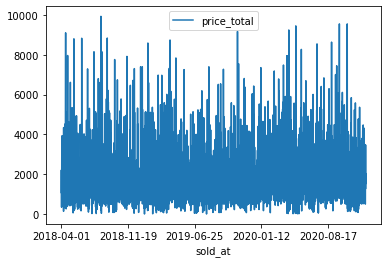

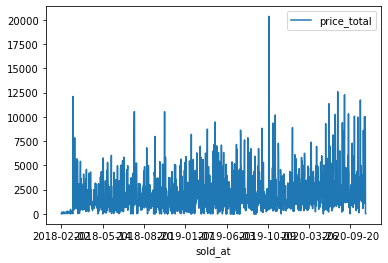

In [150]:
df1.plot(x="sold_at", y="price_total")
df2.plot(x="sold_at", y="price_total")

In [149]:
print(df1.type.unique())
print(df2.type.unique())
print(df3.type.unique())
print(df4.type.unique())
print(df5.type.unique())

['wholesale']
['wholesale']
['wholesale']
['wholesale']
['wholesale']


In [194]:
df1

,global_id,created_at,updated_at,deleted_at,type,price_total,status
sold_at,,,,,,,
2018-04-01,WAJ416859.SA4QNZ5,2018-04-02 05:02:21,2018-04-02 05:02:21,NaN,wholesale,1080.00,sale
2018-04-02,WAJ416859.SA51KYY,2018-04-03 03:22:37,2018-04-03 03:22:37,NaN,wholesale,2208.75,sale
2018-04-02,WAJ416859.SA51MZH,2018-04-03 03:26:06,2018-04-03 03:26:06,NaN,wholesale,1057.50,sale
2018-04-02,WAJ416859.SA51PE7,2018-04-03 03:29:44,2018-04-03 03:29:44,2018-04-05 12:09:41,wholesale,664.50,sale
2018-04-02,WAJ416859.SA51QQC,2018-04-03 03:31:39,2018-04-03 03:31:39,NaN,wholesale,342.50,sale
...,...,...,...,...,...,...,...
2021-01-04,WAJ416859.SA37FBZP,2021-01-06 02:22:42,2021-01-06 02:22:42,NaN,wholesale,1370.50,sale
2021-01-04,WAJ416859.SA37FBZS,2021-01-06 02:22:44,2021-01-06 02:22:44,NaN,wholesale,2050.00,sale
2021-01-04,WAJ416859.SA37FBZV,2021-01-06 02:22:45,2021-01-06 02:22:45,NaN,wholesale,1262.00,sale


In [186]:
df1 = df1.set_index("sold_at")
df_time_series = df1['price_total'].groupby(["sold_at"]).sum()

In [190]:
df_time_series_mean = df1['price_total'].groupby(["sold_at"]).mean()

In [188]:
df_time_series

sold_at
2018-04-01     1080.00
2018-04-02    19719.75
2018-04-03    21499.70
2018-04-04    15374.85
2018-04-05    12961.38
                ...   
2020-12-28    12061.10
2020-12-29     7975.15
2020-12-30    11860.30
2021-01-03     7563.90
2021-01-04     9690.74
Name: price_total, Length: 687, dtype: float64

In [191]:
df_time_series_mean

sold_at
2018-04-01    1080.000000
2018-04-02    1971.975000
2018-04-03    1954.518182
2018-04-04    1537.485000
2018-04-05    1851.625714
                 ...     
2020-12-28    1507.637500
2020-12-29    1329.191667
2020-12-30    1976.716667
2021-01-03    1512.780000
2021-01-04    1938.148000
Name: price_total, Length: 687, dtype: float64

In [193]:
df_time_series.resample('M').mean().plot()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

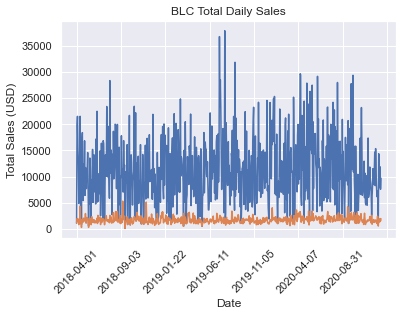

In [192]:
df_time_series.plot()
df_time_series_mean.plot()

plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
plt.title("BLC Total Daily Sales")
plt.xticks(rotation = 45)
plt.show()

In [179]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843 entries, 0 to 1842
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   global_id    1843 non-null   object 
 1   created_at   1843 non-null   object 
 2   updated_at   1843 non-null   object 
 3   deleted_at   152 non-null    object 
 4   type         1843 non-null   object 
 5   sold_at      1843 non-null   object 
 6   price_total  1843 non-null   float64
 7   status       1843 non-null   object 
dtypes: float64(1), object(7)
memory usage: 115.3+ KB


In [180]:
df2['sold_at'] = pd.to_datetime(df2['sold_at'], format='%Y-%m-%d').dt.date

In [182]:
type(df2['sold_at'][0])

datetime.date

In [9]:
os.chdir(analysis_dir)

In [35]:
df1 = pd.read_csv("sales_WAWA1.MM88.csv")
df2 = pd.read_csv("sales_WAWA1.MMIE.csv")
df3 = pd.read_csv("sales_WAWA1.MMV.csv")
df4 = pd.read_csv("sales_WAWA1.MMZ6.csv")
df5 = pd.read_csv("sales_WAWA1.MM2S.csv")

In [20]:
df1 = df1.set_index("sold_at")
df2 = df2.set_index("sold_at")
df3 = df3.set_index("sold_at")
df4 = df4.set_index("sold_at")
df5 = df5.set_index("sold_at")

In [11]:
df1_time_series = df1['price_total'].groupby(["sold_at"]).sum()
df2_time_series = df2['price_total'].groupby(["sold_at"]).sum()
df3_time_series = df3['price_total'].groupby(["sold_at"]).sum()
df4_time_series = df4['price_total'].groupby(["sold_at"]).sum()
df5_time_series = df5['price_total'].groupby(["sold_at"]).sum()

In [12]:
print(len(df1_time_series))
print(len(df2_time_series))
print(len(df3_time_series))
print(len(df4_time_series))
print(len(df5_time_series))

687
642
651
300
371


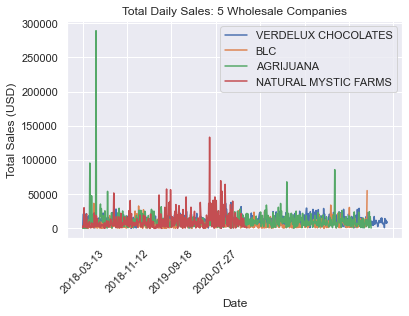

In [17]:
df1_time_series.plot()
df2_time_series.plot()
df3_time_series.plot()
#df4_time_series.plot()
df5_time_series.plot()
labels = ["VERDELUX CHOCOLATES", "BLC", "AGRIJUANA", "QUALITY BRAND", "NATURAL MYSTIC FARMS"]
extra = [ ]
plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
plt.title("Total Daily Sales: 5 Companies")
plt.xticks(rotation = 45)
plt.legend(labels = labels, loc="best")
#plt.xlim(datetime.date(2019,1,1), datetime.date(2019,12,31))
#plt.ylim(0,50_000)
plt.show()

In [200]:
top10_companies_mmeid_name

[(('WAWA1.MMIE', (2049, 35)), 'BLC'),
 (('WAWA1.MMBP', (2033, 35)), 'BINGCANNABIS'),
 (('WAWA1.MMO1', (1717, 35)), 'AMBER BRICK'),
 (('WAWA1.MM2S', (1708, 35)), 'NATURAL MYSTIC FARMS'),
 (('WAWA1.MMZ6', (1541, 35)), 'QUALITY BRAND'),
 (('WAWA1.MMV', (1470, 35)), 'AGRIJUANA'),
 (('WAWA1.MME0', (1411, 35)), 'W.O.W. INDUSTRIES'),
 (('WAWA1.MM88', (1405, 35)), 'VERDELUX CHOCOLATES'),
 (('WAWA1.MM6C', (1394, 35)), 'ALIS GROUP'),
 (('WAWA1.MM126', (1375, 35)), 'ROYALE LEISURE INDUSTRIES')]

In [61]:
df1 = pd.read_csv("sales_WAWA1.MM88.csv")
df2 = pd.read_csv("sales_WAWA1.MMIE.csv")
df3 = pd.read_csv("sales_WAWA1.MMV.csv")
df4 = pd.read_csv("sales_WAWA1.MMZ6.csv")
df5 = pd.read_csv("sales_WAWA1.MM2S.csv")
df1['sold_at'] = pd.to_datetime(df1['sold_at'])
df1 = df1.set_index('sold_at').resample('1M')['price_total'].sum()
df2['sold_at'] = pd.to_datetime(df2['sold_at'])
df2 = df2.set_index('sold_at').resample('1M')['price_total'].sum()
df3['sold_at'] = pd.to_datetime(df3['sold_at'])
df3 = df3.set_index('sold_at').resample('1M')['price_total'].sum()
df4['sold_at'] = pd.to_datetime(df4['sold_at'])
df4 = df4.set_index('sold_at').resample('1M')['price_total'].sum()
df5['sold_at'] = pd.to_datetime(df5['sold_at'])
df5 = df5.set_index('sold_at').resample('1M')['price_total'].sum()

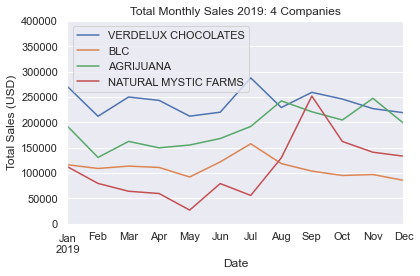

In [64]:
df1.plot()
df2.plot()
df3.plot()
#df4.plot()
df5.plot()
labels = ["VERDELUX CHOCOLATES", "BLC", "AGRIJUANA", "NATURAL MYSTIC FARMS"]
extra = ["QUALITY BRAND", ]
plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
plt.title("Total Monthly Sales 2019: 4 Companies")
#plt.xticks(rotation = 45)
plt.legend(labels = labels, loc="best")
plt.xlim(datetime.date(2019,1,1), datetime.date(2019,12,31))
plt.ylim(0,400_000)
plt.tight_layout()
plt.savefig("capstone_pitch_1.png")
plt.show()

In [40]:
df1 = pd.read_csv("sales_WAWA1.MM88.csv")
df2 = pd.read_csv("sales_WAWA1.MMIE.csv")
df3 = pd.read_csv("sales_WAWA1.MMV.csv")
df4 = pd.read_csv("sales_WAWA1.MMZ6.csv")
df5 = pd.read_csv("sales_WAWA1.MM2S.csv")
df1['sold_at'] = pd.to_datetime(df1['sold_at'])
df1 = df1.set_index('sold_at').resample('1D')['price_total'].sum()
df2['sold_at'] = pd.to_datetime(df2['sold_at'])
df2 = df2.set_index('sold_at').resample('1D')['price_total'].sum()
df3['sold_at'] = pd.to_datetime(df3['sold_at'])
df3 = df3.set_index('sold_at').resample('1D')['price_total'].sum()
df4['sold_at'] = pd.to_datetime(df4['sold_at'])
df4 = df4.set_index('sold_at').resample('1D')['price_total'].sum()
df5['sold_at'] = pd.to_datetime(df5['sold_at'])
df5 = df5.set_index('sold_at').resample('1D')['price_total'].sum()

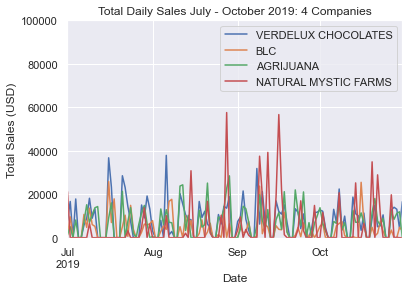

<Figure size 432x288 with 0 Axes>

In [41]:
df1.plot()
df2.plot()
df3.plot()
#df4.plot()
df5.plot()
labels = ["VERDELUX CHOCOLATES", "BLC", "AGRIJUANA", "NATURAL MYSTIC FARMS"]
extra = ["QUALITY BRAND", ]
plt.xlabel('Date')
plt.ylabel('Total Sales (USD)')
plt.title("Total Daily Sales July - October 2019: 4 Companies")
#plt.xticks(rotation = 45)
plt.legend(labels = labels, loc="best")
plt.xlim(datetime.date(2019,7,1), datetime.date(2019,10,31))
plt.ylim(0,100_000)
plt.show()
plt.savefig("capstone_pitch_2.png")

In [48]:
os.getcwd()

'E:\\TDI_Capstone_Data_Repo\\main-repo'

In [49]:
os.listdir()

['reduced_saleitems0',
 'reduced_labResults-Apr2021',
 'inventories-reduced',
 'dask-worker-space',
 'reduced_saleitems1',
 '000.csv',
 'tmp-000.csv',
 'single-file-repo',
 'Licensees_0',
 'analysis_dir',
 'sales',
 'sales_WAWA1.MM88.csv',
 'sales_WAWA1.MMIE.csv',
 'sales_WAWA1.MMV.csv',
 'sales_WAWA1.MMZ6.csv',
 'sales_WAWA1.MM2S.csv',
 'capstone_pitch_2.png']

In [64]:
companies_sales610_files = ['WAWA1.MME0', 'WAWA1.MM126', 'WAWA1.MMBP', 'WAWA1.MM6C', 'WAWA1.MMO1']

In [65]:
individualfiles_datetime_to_date(companies_sales610_files, "sold_at")

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'WAWA1.MME0'

In [56]:
df6 = pd.read_csv(companies_sales610_files[0])
df7 = pd.read_csv(companies_sales610_files[1])
df8 = pd.read_csv(companies_sales610_files[2])
df9 = pd.read_csv(companies_sales610_files[3])
df10 = pd.read_csv(companies_sales610_files[4])

In [58]:
dfs_list2 = [df6, df7, df8, df9, df10]

In [62]:
shapes, unique = [], []
for i in tqdm(range(len(dfs_list2)), desc="Progress"):
    shapes.append(dfs_list2[i].shape)
    unique.append(dfs_list2[i].type.value_counts())
print(shapes)    
print(unique)    

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

[(4563, 8), (1843, 8), (2867, 8), (828, 8), (846, 8)]
[wholesale    4563
Name: type, dtype: int64, wholesale    1843
Name: type, dtype: int64, wholesale    2867
Name: type, dtype: int64, wholesale    828
Name: type, dtype: int64, wholesale    846
Name: type, dtype: int64]


In [ ]:
[('WAWA1.MM88', 27180),
 ('WAWA1.MMIE', 17914),
 ('WAWA1.MMV', 16349),
 ('WAWA1.MMZ6', 8994),
 ('WAWA1.MM2S', 7010),


In [ ]:
os.chdir(analysis)
#pull_sales_data(companies_mmeid_6to10companies, sales_df)